In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

In [59]:
#import data
df = pd.read_csv('/Users/lennardreihs/EPFL/Master/MA2/AI4chem/ai4chem/docs/data/cycpeptdb_clean.csv', header = 0)
n = len(df)
tpsa_values = np.array(df['TPSA'])
logp_values = np.array(df['Permeability'])
mw_values = np.array(df['MolWt'])
sequence_logp_string = np.array(df['Sequence_LogP'].tolist())
sequence_logp = [ast.literal_eval(s) for s in sequence_logp_string]
fr_values_df = df[[col for col in df.columns if col.startswith('fr_')]]
fr_values = np.zeros((n, len(fr_values_df.iloc[1,:])))
for i in range(n):
    fr_values[i] = np.array(fr_values_df.iloc[i,:].values.tolist())

[(-3.0, -10.0),
 (-3.0, -10.0),
 Text(0.5, 0, '$\\log{P}_{\\mathrm{exp}}$'),
 Text(0, 0.5, '$\\log{P}_{\\mathrm{pred}}$')]

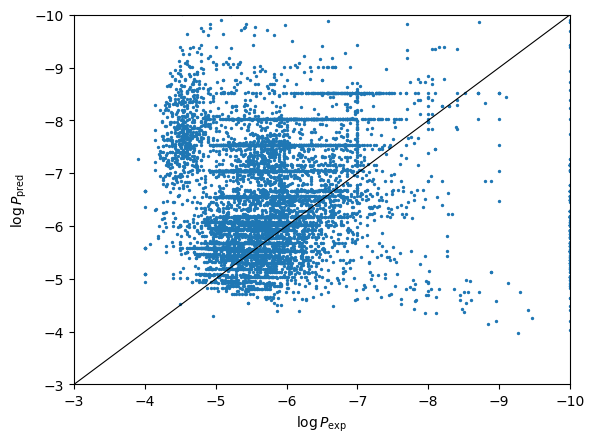

In [60]:
logp_pred_barret = 0.008 * mw_values - 0.043 * tpsa_values - 5.165 #empirical relation from Barret (2018)

fig, ax = plt.subplots()
ax.scatter(logp_values, logp_pred_barret, s = 2)
ax.plot((0,-30), (0,-30), c = 'k', lw = .8)
ax.set(xlim = (-3,-10), ylim = (-3,-10), xlabel = r'$\log{P}_{\mathrm{exp}}$', ylabel = r'$\log{P}_{\mathrm{pred}}$')

In [145]:
def linear_regression(X, y, lamb):
    return np.linalg.inv(X.T.dot(X)+lamb*np.eye(X.shape[1])).dot(X.T).dot(y)

def test_error(X, y, w):
    return 1/len(y)*np.sum((y-X@w)**2)

Error = 1.1053422161629505


[Text(0.5, 0, '$\\lambda$'), Text(0, 0.5, 'error')]

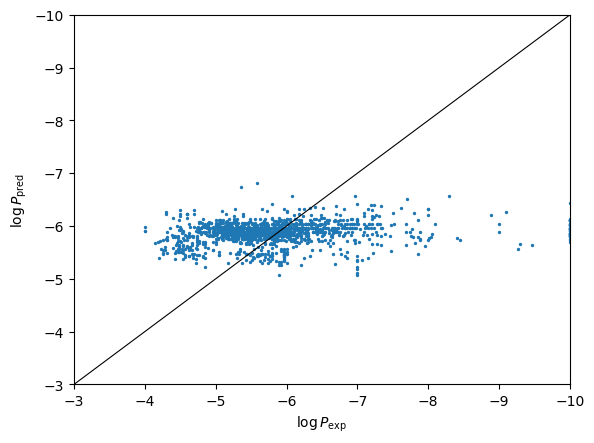

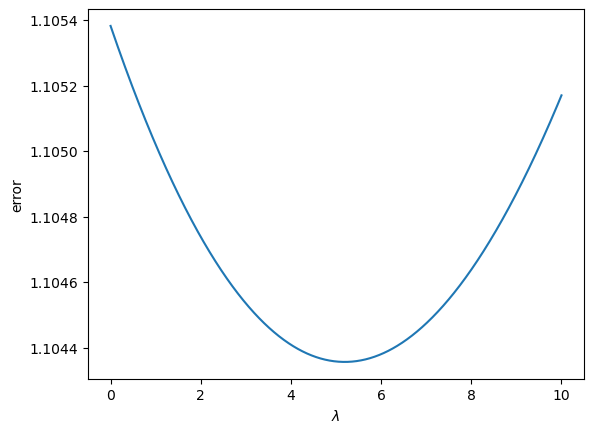

In [153]:
# Regression model 1: MW & TPSA

X1_tot = [[mw_values[i], tpsa_values[i], 1.0] for i in range(n)]
y1_tot = logp_values

X1_t, X1_test, y1_t, y1_test = train_test_split(X1_tot, y1_tot, test_size=0.2)
X1_train, X1_validation, y1_train, y1_validation = train_test_split(X1_t, y1_t, test_size=0.25)

w1 = linear_regression(np.array(X1_train), np.array(y1_train), lamb=0.1)
logp_pred_model1 = X1_test@w1

print(f'Error = {test_error(X1_test, y1_test, w1)}')

fig, ax = plt.subplots()
ax.scatter(y1_test, logp_pred_model1, s = 2)
ax.plot((0,-30), (0,-30), c = 'k', lw = .8)
ax.set(xlim = (-3,-10), ylim = (-3,-10), xlabel = r'$\log{P}_{\mathrm{exp}}$', ylabel = r'$\log{P}_{\mathrm{pred}}$')

lambdas = np.linspace(0,10,1000)
errors = []

for lambda_ in lambdas:
    w1_lambda = linear_regression(np.array(X1_train), np.array(y1_train), lambda_)
    errors.append(test_error(X1_test, y1_test, w1_lambda))

fig, ax = plt.subplots()
ax.plot(lambdas, errors)
ax.set(xlabel = r'$\lambda$', ylabel = 'error')

Error = 0.9477372563707053


[(-3.0, -10.0),
 (-3.0, -10.0),
 Text(0.5, 0, '$\\log{P}_{\\mathrm{exp}}$'),
 Text(0, 0.5, '$\\log{P}_{\\mathrm{pred}}$')]

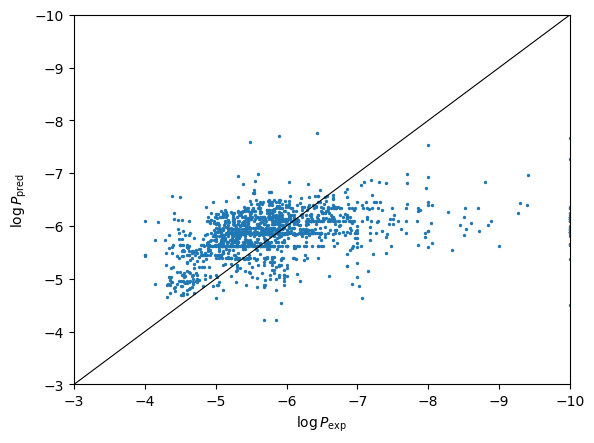

In [160]:
# Regression model 2: features

X2_tot = [np.append(fr_values[i], 1.0) for i in range(n)]
y2_tot = logp_values

X2_t, X2_test, y2_t, y2_test = train_test_split(X2_tot, y2_tot, test_size=0.2)
X2_train, X2_validation, y2_train, y2_validation = train_test_split(X2_t, y2_t, test_size=0.25)

w2 = linear_regression(np.array(X2_train), np.array(y2_train), lamb=0.1)
logp_pred_model2 = X2_test@w2

print(f'Error = {test_error(X2_test, y2_test, w2)}')

fig, ax = plt.subplots()
ax.scatter(y2_test, logp_pred_model2, s = 2)
ax.plot((0,-30), (0,-30), c = 'k', lw = .8)
ax.set(xlim = (-3,-10), ylim = (-3,-10), xlabel = r'$\log{P}_{\mathrm{exp}}$', ylabel = r'$\log{P}_{\mathrm{pred}}$')